<a href="https://colab.research.google.com/github/mark878/ml/blob/ml-1/IdentifyingIrisPlantsWithMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Iris Plants with Machine Learning

In this lab, we are going to replicate a famous experiment performed by Sir Ronald Fisher in his 1936 paper *The use of multiple measurements in taxonomic problems*. Why are we repeating a nearly 100-year-old experiment? Because now we can let a machine learn how to do it instead of doing the math ourselves. Yeah!

## First, you need to make a copy of this notebook for yourself.
In the top menu, choose File -> Save a Copy in Drive. Save a copy for yourself in your own Google Drive for later reference! Continue with the lab on your copy.

### I'm excited! What are we going to do?
I'm glad you asked. Fisher's dataset contains data related to 3 different species of Iris plants: *Iris setosa*, *Iris versicolor*, and *Iris virginica*, with 50 sets of data points for each species. Each data point consists of 4 features:
 * Sepal length
 * Sepal width
 * Petal length
 * Petal width

All of these features are measured in centimeters. Petals you're probably familiar with, but sepals are the green leaf-like structures directly under the petals that support them. By taking these 4 measurements, he was able to statistically (and reliably!) predict the species from measurements of an unknown flower. We're going to do the same thing, but use machine learning to make the prediction for us.

## 1. Load the Data

First, we have to do our standard imports. We'll also check which version of TensorFlow we're using - any version >= 2.3.0 should work. This loads the libraries we'll need for the rest of the exercise. Run the cell by pressing the Play button on the left side, or pressing Control + Enter on your keyboard.


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

print(tf.__version__)

2.14.0


The Iris dataset is so well known that TensorFlow has an automatic way to import the original dataset, which we will use to train our model. This cell also downloads a set of 30 iris data examples that we can use to test our model once it is trained.

We will be using two libraries to help us work with the data: NumPy and Pandas. The only thing you need to know for the moment is that Pandas uses a structure called a DataFrame, commonly abbreviated as `df`, to hold the data. These two libraries will be important as you continue your machine learning journey.

In [2]:
#Training Data - Using TensorFlow to automatically load
iris_features = ["sepal_length", "sepal_width", "petal_length","petal_width"]
iris_labels = ["Iris setosa", "Iris versicolor", "Iris virginica"]

training_features, training_labels = tfds.as_numpy(tfds.load('iris', split='train', as_supervised=True, batch_size=-1))
iris_df = pd.DataFrame(data=training_features, columns=iris_features)
iris_df['species'] = [iris_labels[x] for x in training_labels]

#Testing Data - Downloading the test data, then loading it
test_col_names = iris_features + ['species']
test_data_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"
test_file = tf.keras.utils.get_file(fname=os.path.basename(test_data_url), origin=test_data_url)

test_df = pd.read_csv(test_file, delimiter=',', skiprows=1, header=None, names=test_col_names)

test_features = test_df.iloc[:,0:4]
test_labels = test_df.iloc[:,-1]
test_df['species'] = [iris_labels[x] for x in test_labels]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/150 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/iris/2.1.0.incomplete18UZLF/iris-train.tfrecord*...:   0%|          | 0/15…

Dataset iris downloaded and prepared to /root/tensorflow_datasets/iris/2.1.0. Subsequent calls will reuse this data.
573/573 [==============================] - 0s 0us/step


## 2. Visualize the Data

Let's start with a simple count. We expect to have 150 sets of features in the training set, as well as 150 labels. We'll print the length of the lists containing the features and labels for the training and test sets.

In [3]:
print(f"Training data. Features: {len(training_features)}. Labels: {len(training_labels)}.")
print(f"Testing data.  Features: {len(test_features)}. Labels: {len(test_labels)}.")

Training data. Features: 150. Labels: 150.
Testing data.  Features: 30. Labels: 30.


That was a lot of code to show us 4 numbers. Let's let Pandas do the heavy lifting. We'll examine statistics about the training and test data calculated automatically for us by the DataFrame.

Run the next two cells and take a look at the statistics.

In [4]:
iris_df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758666,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
test_df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,30.000000,30.000000,30.000000,30.000000
mean,5.836667,3.010000,3.836667,1.206667
std,0.653628,0.463383,1.537459,0.694775
min,4.300000,2.200000,1.100000,0.100000
25%,5.500000,2.725000,2.300000,0.625000
50%,5.750000,3.000000,4.250000,1.300000
75%,6.300000,3.300000,4.900000,1.575000
max,7.100000,4.200000,5.900000,2.500000


Now that we've seen the big picture, let's look at some individual data points. We'll look at the top 15 examples in the training and test data. For context, remember that these data points are measurements in centimeters.

Run the following two cells.

In [6]:
iris_df.head(15)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.4,1.5,0.2,Iris setosa
1,7.7,3.0,6.1,2.3,Iris virginica
2,5.7,2.8,4.5,1.3,Iris versicolor
3,6.8,3.2,5.9,2.3,Iris virginica
4,5.2,3.4,1.4,0.2,Iris setosa
5,5.6,2.9,3.6,1.3,Iris versicolor
6,5.5,2.6,4.4,1.2,Iris versicolor
7,5.5,2.4,3.7,1.0,Iris versicolor
8,4.6,3.4,1.4,0.3,Iris setosa
9,7.7,2.8,6.7,2.0,Iris virginica


In [7]:
test_df.head(15)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.9,3.0,4.2,1.5,Iris versicolor
1,6.9,3.1,5.4,2.1,Iris virginica
2,5.1,3.3,1.7,0.5,Iris setosa
3,6.0,3.4,4.5,1.6,Iris versicolor
4,5.5,2.5,4.0,1.3,Iris versicolor
5,6.2,2.9,4.3,1.3,Iris versicolor
6,5.5,4.2,1.4,0.2,Iris setosa
7,6.3,2.8,5.1,1.5,Iris virginica
8,5.6,3.0,4.1,1.3,Iris versicolor
9,6.7,2.5,5.8,1.8,Iris virginica


### Wait. There is another column in this view.

Yes, there is. How do you expect to calculate mean and standard deviation on plain text? The DataFrame was smart enough to not include this column in the ```describe``` statistics.

Looking at the individual data points allows us to see the species, which is our label. I've cleaned this up a bit for you to make it easier to read. In the raw data, the species is a 0, 1, or 2. It's much nicer to look at the actual species name.

This still looks like alphanumeric soup, though. There are another 135 rows of data we didn't even look at. We need a better way to visualize the data. Pandas to the rescue again! We'll create a scatter matrix, which graphs each feature against every other feature. This works well because all of the features have the same unit of measurement, and we only have four features, so the graphs aren't out of control. Along the diagonal where a feature would graph against itself is instead a histogram showing the distribution of that feature. Super useful!

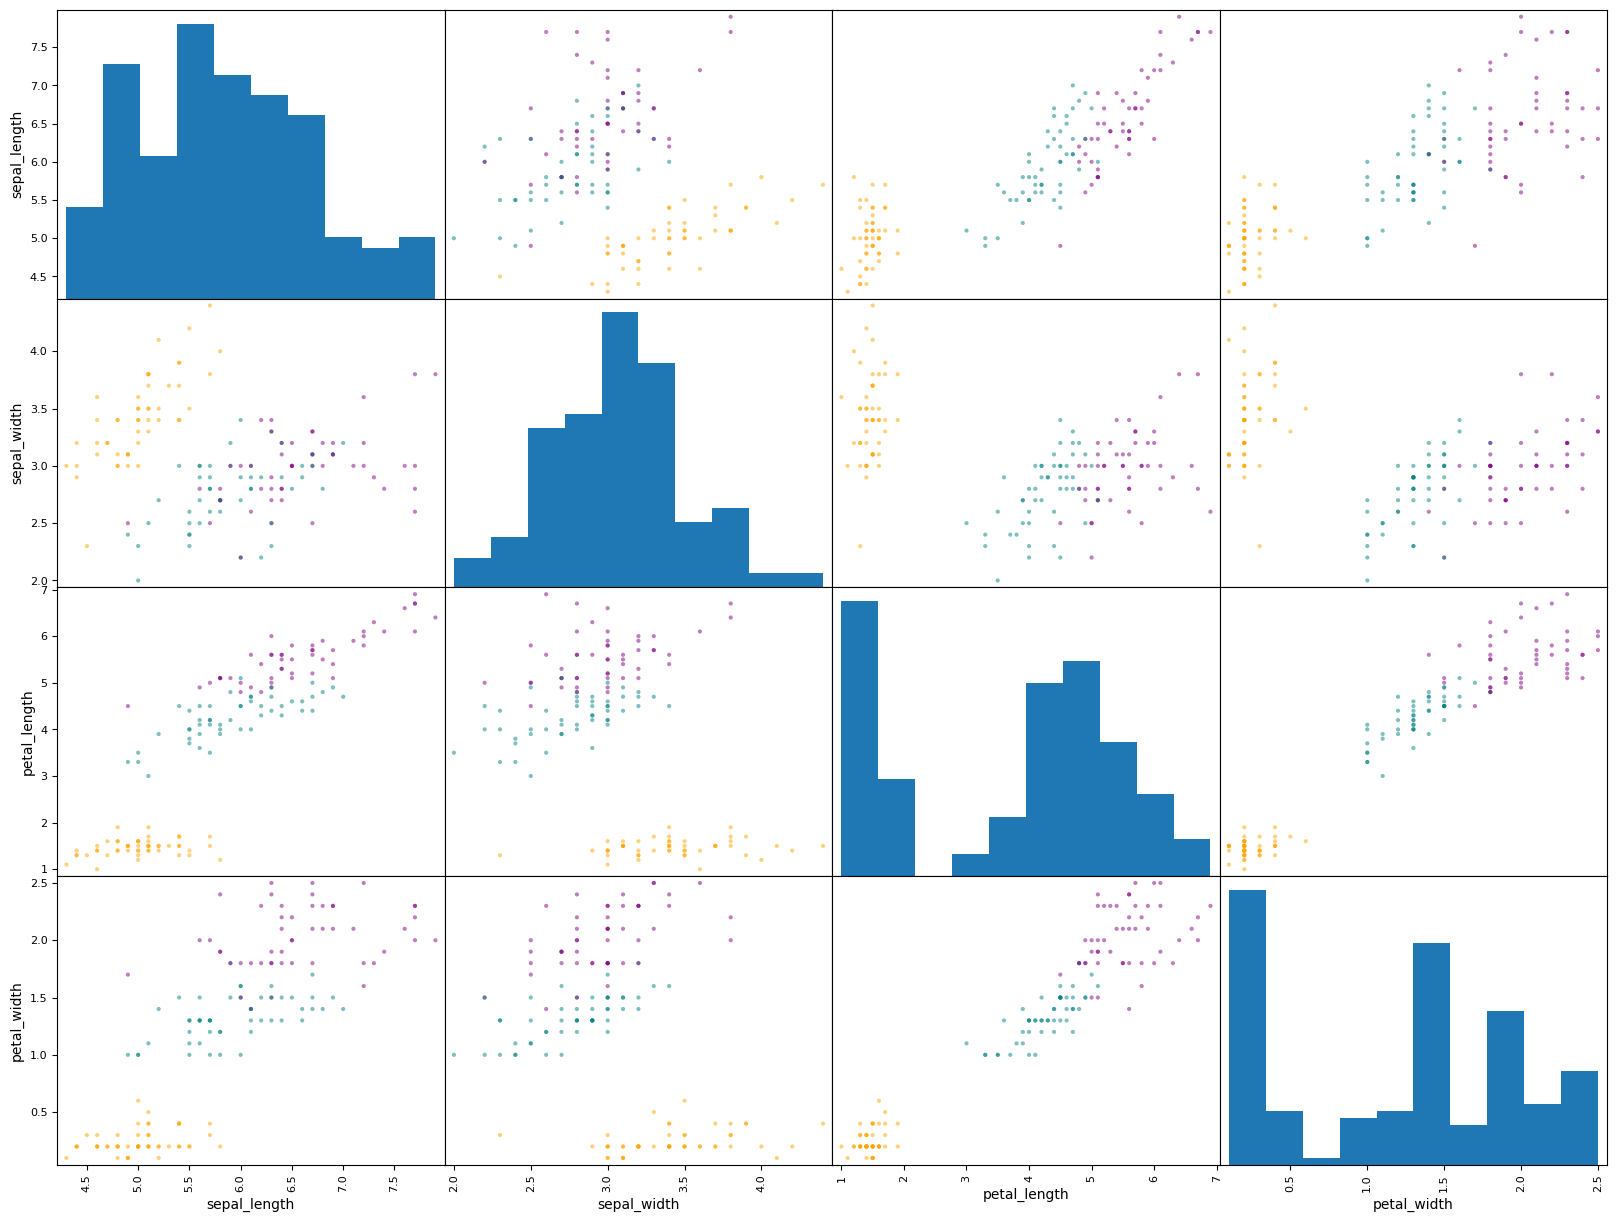

In [8]:
colormap = {'Iris setosa':'orange', 'Iris versicolor':'teal', 'Iris virginica':'purple'}
colors = iris_df['species'].map(lambda x: colormap[x])
scattermatrix = pd.plotting.scatter_matrix(iris_df, color=colors, figsize=(20,15))

We can visualize this one more way on a RadViz plot. This shows us how separable the data is by the different features.

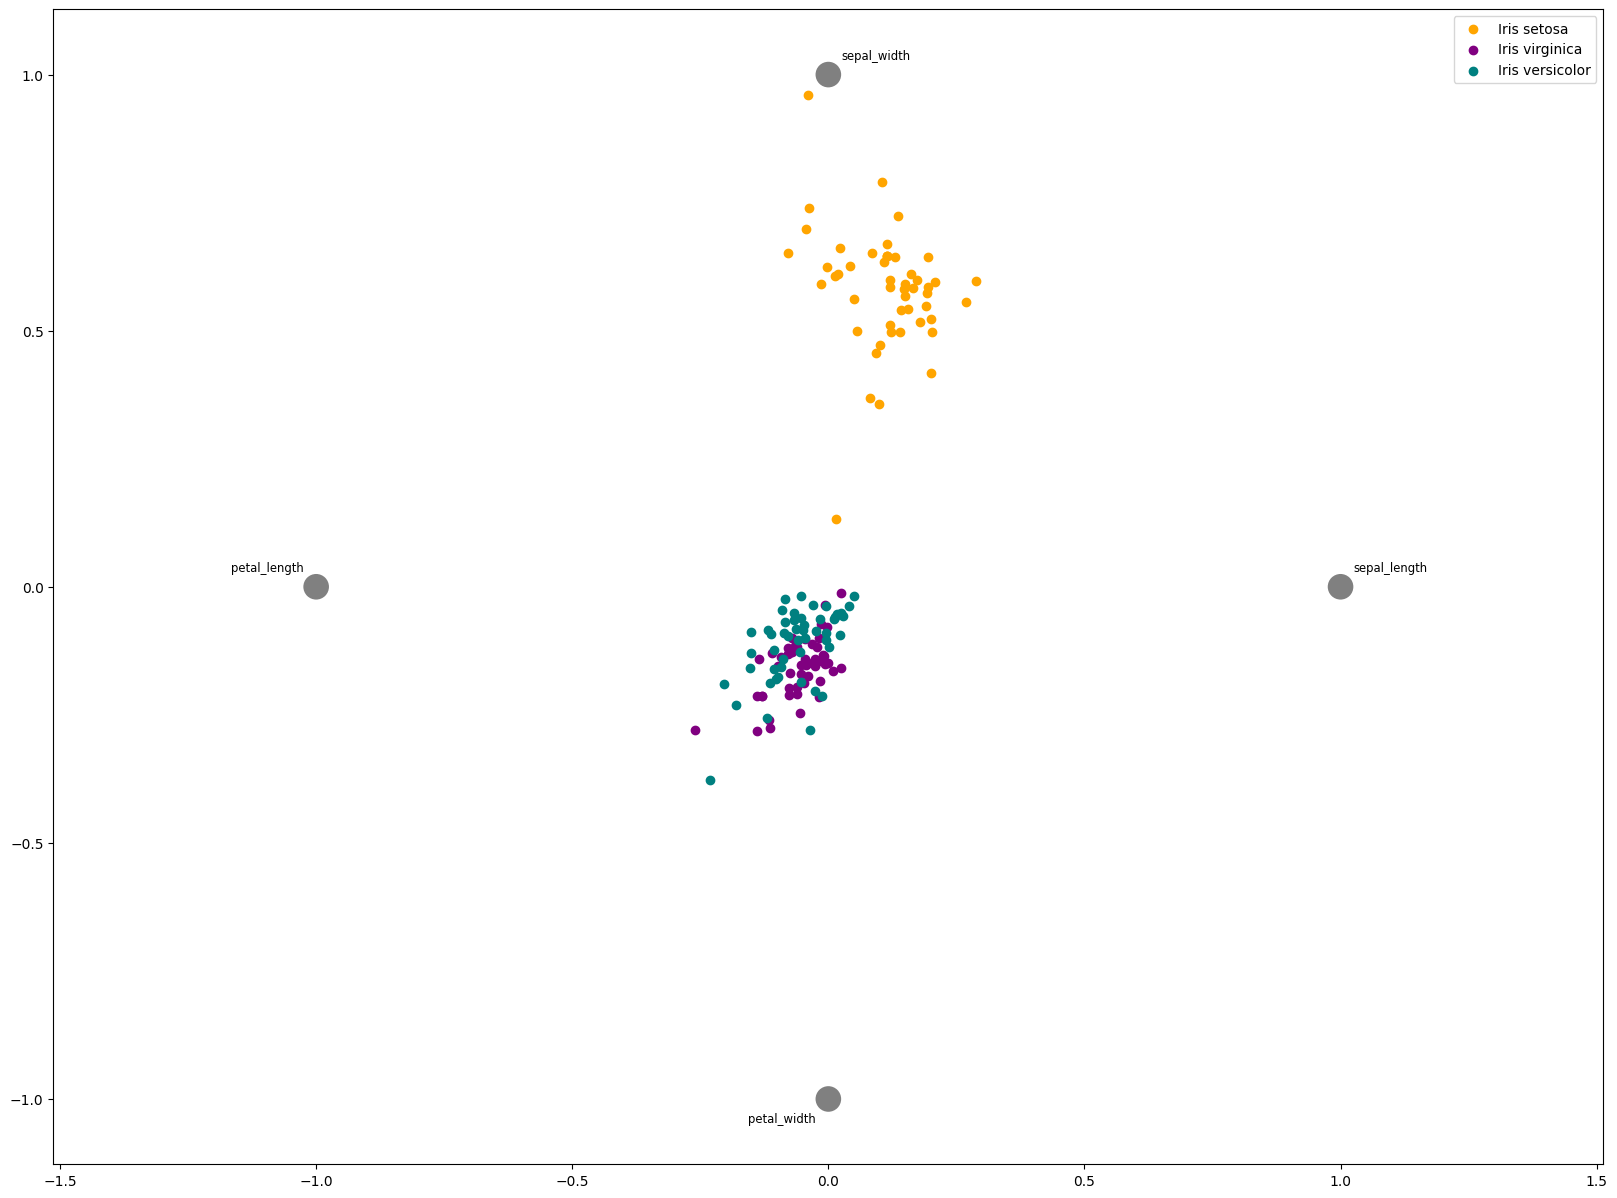

In [9]:
plt.figure(figsize=(20,15))
radviz = pd.plotting.radviz(iris_df, 'species', color=colors)

We can see that the *Iris setosa*, shown in orange, is pretty easy to separate from the other two. You can draw a line through every one of those graphs to separate it from the other two labels, also called classes. Unfortunately, telling *Iris versicolor* from *Iris virginica* is more difficult. We can't definitively separate those two classes with a simple line because the examples are very close together, and even overlap substantially. Lucky for us, we have a way to let the machine learn the differences so we don't have to!

## 3. Teach the Machine about Irises

TensorFlow allows us to have as much control over the machine learning process as we need. Since we're working on a pretty small problem that we don't need to fiddle with too much, we're going to work with TensorFlow using a high-level framework called Keras that allows us to get right to work without having to tweak a bunch of settings. As you go about your own machine learning projects, it's usually a good idea to try the simplest method first. If nothing else, it gives you a good baseline to compare more complex methods against.

A lot of trial and error goes into finding a good architecture for understanding your individual data. This data, however, has been solved many times before, so architectures that produce decent results are widely known. We're going to use a fairly simple Neural Network. The input shape is `(4,)` because we're passing in 4 features (petal and sepal length and width). The hidden layers are densely connected.  The last layer is our output, and it requires 3 neurons, one for each of the three classes we are training the machine to identify. The output will be logits, which is an individual probability metric for how likely the machine thinks the features belong to each class.

We also have to tell it how to correct itself (the `adam` optimizer), what it should use to judge correctness (Sparse Categorical Crossentropy) and any other metrics we'd like it to report (Sparse Categorical Accuracy: How much of the  time was the class prediction correct?).

### Woah, hoss. Back up. That was a lot of fancy words.
You're right, it was. I hope your eyes didn't glaze over too badly. I wanted to introduce you to what we were doing so you get some exposure to the terminology, but fear not! I have a shorter summary that will probably make more sense.

We're going to use a structure that mimics the way the human brain works to teach the machine about irises. We have to tell it how many features to expect for each example (4), how many combinations of information it can learn (total number of connections, which is 4 (our input) x 10 x 10 x 3), how complex we expect the data to be to learn (mostly related to how many hidden layers we have, 2), and finally, what we expect the output to be (a probability score).


### You said that was going to be simpler.
Fair enough. That was still pretty complex. Don't worry too much about the finer points right now. This is your first model. That's why I'm giving you all the code you need so you can build it today and study it later.

In [11]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
  ])

iris_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

Ok, so we built our structure, but it isn't trained yet. We haven't actually shown it any data. That's what this next step will do. We'll use the ```fit``` method to train our architecture what the data should look like. We will show it 16 examples (rows) at a time and have it update its weights after seeing those. We'll do this for 100 epochs, which means we will show it the full training dataset 100 times. Have you ever studied something multiple times to understand it better? That's exactly what we're having the machine do.

In [12]:
iris_model.fit(training_features, training_labels, verbose=2, batch_size=16, epochs=100)

Epoch 1/100
10/10 - 1s - loss: 1.2750 - sparse_categorical_accuracy: 0.3333 - 816ms/epoch - 82ms/step
Epoch 2/100
10/10 - 0s - loss: 1.2002 - sparse_categorical_accuracy: 0.3533 - 22ms/epoch - 2ms/step
Epoch 3/100
10/10 - 0s - loss: 1.1452 - sparse_categorical_accuracy: 0.6267 - 21ms/epoch - 2ms/step
Epoch 4/100
10/10 - 0s - loss: 1.1023 - sparse_categorical_accuracy: 0.6667 - 21ms/epoch - 2ms/step
Epoch 5/100
10/10 - 0s - loss: 1.0702 - sparse_categorical_accuracy: 0.6667 - 20ms/epoch - 2ms/step
Epoch 6/100
10/10 - 0s - loss: 1.0475 - sparse_categorical_accuracy: 0.6667 - 20ms/epoch - 2ms/step
Epoch 7/100
10/10 - 0s - loss: 1.0272 - sparse_categorical_accuracy: 0.6667 - 20ms/epoch - 2ms/step
Epoch 8/100
10/10 - 0s - loss: 1.0093 - sparse_categorical_accuracy: 0.6667 - 26ms/epoch - 3ms/step
Epoch 9/100
10/10 - 0s - loss: 0.9948 - sparse_categorical_accuracy: 0.6667 - 24ms/epoch - 2ms/step
Epoch 10/100
10/10 - 0s - loss: 0.9776 - sparse_categorical_accuracy: 0.6667 - 21ms/epoch - 2ms/st

My `sparse_categorical_accuracy` came out to 0.9733, which means it predicted correctly 97.33% of the time on the training data. That's not bad for only having 150 data points! How did you do? Your value should be close to that, but might not be exactly the same.

Let's take a look at the predictions. We're going to define a short function to make our predictions, then format them for easier viewing. The actual predictions are being made when we use `iris_model.predict`. Everything after that is just some clever output formatting.

In [13]:
def predict(features, labels):
    predictions = iris_model.predict(features)

    pred_df = pd.DataFrame(columns=['Actual','Prediction'])
    pred_df['Actual'] = [iris_labels[x] for x in labels]
    pred_df['Prediction'] = [iris_labels[x] for x in [np.argmax(p) for p in predictions]]
    pred_df['Correct'] = pred_df['Actual'] == pred_df['Prediction']

    return pred_df

Normally, you don't try to predict using the data you used for training, but since we have limited data, we're going to do it just to see what the output should look like. We'll see the `Actual` value, which is the true species of the flower. Beside that, we'll see what `Prediction` for the species that the model made, and finally if the prediction was `Correct`. That's much easier to read than comparing the values ourselves. We'll look at the first 30 rows.

In [14]:
training_predictions = predict(training_features[:30], training_labels[:30])
training_predictions

1/1 [==============================] - 0s 85ms/step


,Actual,Prediction,Correct
0,Iris setosa,Iris setosa,True
1,Iris virginica,Iris virginica,True
2,Iris versicolor,Iris versicolor,True
3,Iris virginica,Iris virginica,True
4,Iris setosa,Iris setosa,True
5,Iris versicolor,Iris versicolor,True
6,Iris versicolor,Iris versicolor,True
7,Iris versicolor,Iris versicolor,True
8,Iris setosa,Iris setosa,True
9,Iris virginica,Iris virginica,True


It shows exactly what we expected from the accuracy percentage: it's nearly always right.

But now, how do we get the same accuracy score for our test data? We have another function exactly for this: `evaluate`! We can pass it our test features and test labels, and it will calculate the same metrics it did as the model was training.

In [15]:
iris_model.evaluate(test_features, test_labels)

1/1 [==============================] - 0s 161ms/step - loss: 0.1270 - sparse_categorical_accuracy: 1.0000


[0.12697546184062958, 1.0]

My accuracy is 0.9667, or 96.67%. That's about half a percentage point difference from the training accuracy, which means this model is well trained.

Finally, let's use our fancy formatting function to take a look at the test data set predictions.

In [16]:
test_predictions = predict(test_features, test_labels)
test_predictions

1/1 [==============================] - 0s 89ms/step


,Actual,Prediction,Correct
0,Iris versicolor,Iris versicolor,True
1,Iris virginica,Iris virginica,True
2,Iris setosa,Iris setosa,True
3,Iris versicolor,Iris versicolor,True
4,Iris versicolor,Iris versicolor,True
5,Iris versicolor,Iris versicolor,True
6,Iris setosa,Iris setosa,True
7,Iris virginica,Iris virginica,True
8,Iris versicolor,Iris versicolor,True
9,Iris virginica,Iris virginica,True


## Congratulations on building your first machine learning model!
Compile, Fit, Evaluate, Predict. It's just that easy. You're off to a great start on your machine learning journey!